In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,average_precision_score,roc_curve,auc,precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.ensemble import BaggingClassifier 

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.externals import joblib

import xgboost as xgb
from scipy import interp

import random

from __future__ import division
from __future__ import print_function

# Read file and wrangling targets

In [2]:
dataset_modelA_clean = pd.read_csv("/group/axa_thai/jiannan/AXAKT_Delivery/Data/dataset_2016-02_2016-05.csv",sep="|",na_values=["\N", "NULL"])

In [3]:
#Drop ModelB targets
new_set_flg = True

if new_set_flg:
    modelB_targets = ['target_rider_all_max','target_rider_waiver_premium_max','target_rider_health_max',
                      'target_rider_accident_max','target_rider_critical_illness_max','target_rider_term_max']
    dataset_modelA_clean = dataset_modelA_clean.drop(modelB_targets, axis=1)


In [4]:
dataset_modelA_clean=dataset_modelA_clean.rename(columns = {'target_whole_life_max':'target_whole_life',
                                 'target_endowment_max':'target_endowment',
                                 'target_retirement_max':'target_retirement',
                                 'target_short_term_saving_max':'target_short_term_saving',
                                 'target_term_life_max':'target_term_life',
                                 'target_universal_life_max':'target_universal_life',
                                 'target_health_max':'target_health',
                                 'target_all_max':'target_all'
                                               })

# Start Targeting 

# Get feature columns

In [5]:
ALL_TARGETS = ['target_whole_life','target_endowment','target_retirement','target_short_term_saving','target_term_life',
               'target_universal_life','target_health','target_all']

In [6]:
targeting_features_file = '/group/axa_thai/jiannan/AXAKT_Delivery/Cols/modelA_targeting_features.csv'
feature_df_targeting = pd.read_csv(targeting_features_file,na_values=["\N","NULL"])

features_columns_targeting = feature_df_targeting.targeting_features.tolist()

print(len(features_columns_targeting))

387


In [7]:
targeting_features_file = '/group/axa_thai/jiannan/AXAKT_Delivery/Cols/modelA_reco_features.csv'
feature_df_reco = pd.read_csv(targeting_features_file,na_values=["\N","NULL"])

features_columns_reco = feature_df_reco.reco_features.tolist()

print(len(features_columns_reco))

412


In [8]:
# get data set for targeting
dataset_modelA_clean_targeting = dataset_modelA_clean[np.concatenate([features_columns_targeting, ALL_TARGETS])].copy()

# get data set for recommendation
dataset_modelA_clean_reco = dataset_modelA_clean[np.concatenate([features_columns_reco, ALL_TARGETS])].copy()

In [9]:
X_train = dataset_modelA_clean_targeting.drop(ALL_TARGETS, axis=1)

In [10]:
#check target percentage in population
print(ALL_TARGETS)

for target in ALL_TARGETS:
    print("target proportion %s"%target)
    print(dataset_modelA_clean_targeting[target].mean())
    print(dataset_modelA_clean_targeting[target].mean())

['target_whole_life', 'target_endowment', 'target_retirement', 'target_short_term_saving', 'target_term_life', 'target_universal_life', 'target_health', 'target_all']
target proportion target_whole_life
0.0174090258767
0.0174090258767
target proportion target_endowment
0.000325493158571
0.000325493158571
target proportion target_retirement
0.000540464386433
0.000540464386433
target proportion target_short_term_saving
0.00165297085379
0.00165297085379
target proportion target_term_life
0.000785798782073
0.000785798782073
target proportion target_universal_life
0.000456662043368
0.000456662043368
target proportion target_health
0.00082709269025
0.00082709269025
target proportion target_all
0.0215432748012
0.0215432748012


# Create targeting model and store it as pickle object

In [11]:
print('Start TARGETING MODELA CREATION WITH BAGGING OF XGB')

target = 'target_all'

clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=6, n_estimators=420, learning_rate=0.05,
                        max_delta_step=1, min_child_weight=25, gamma=0.1, scale_pos_weight=0.85, colsample_bytree=0.85,
                        subsample=0.85, colsample_bylevel=1, nthread=12, seed=27)

clfbag_targeting = BaggingClassifier(clf, n_estimators=10, max_samples=0.9, max_features=0.9)

train_X = X_train[features_columns_targeting].drop(['svocmasterid'], axis=1).reset_index(drop=True)

y_train = np.array(dataset_modelA_clean_targeting[target].astype(np.uint8))

clfbag_targeting.fit(train_X, y_train)

print('STROING MODELA TARGETING MODEL TO PICKLE')
joblib.dump(clfbag_targeting, config["model_path"]+'Xsell_model_A_Targeting_%s.pkl' % (config["model_date"]), compress=1)
print('DONE!')


Start TARGETING MODELA CREATION WITH BAGGING OF XGB


KeyboardInterrupt: 

# Preparation for Recommendation Model Creation

In [12]:
print('PREPARATION FOR RECOMMENDATION MODEL CREATION')
target = 'target_multi'
# We reorder products from the least sell to the most sell
probas_cols = ['prob_of_endowment', 'prob_of_universal_life', 'prob_of_retirement', 'prob_of_term_life',
               'prob_of_health', 'prob_of_short_term_saving', 'prob_of_whole_life']
target_cols = [u'target_endowment', u'target_universal_life', u'target_retirement',
               u'target_term_life', u'target_health', u'target_short_term_saving', u'target_whole_life']
products = ['endowment', 'universal_life', 'retirement', 'term_life', 'health', 'short_term_saving', 'whole_life']
products_name = ['endowment', 'universal_life', 'retirement', 'term_life', 'health', 'short_term_saving', 'whole_life']
target_map = {u'endowment': 0, u'universal_life': 1, u'retirement': 2,
              u'term_life': 3, u'health': 4, u'short_term_saving': 5, u'whole_life': 6}
inv_target_map = {0: 'endowment', 1: 'universal_life', 2: 'retirement', 3: 'term_life', 4: 'health',
                  5: 'short_term_saving', 6: 'whole_life'}

# We only train the multiclassifier on customer who indeed bought something
dataset_modelA_reco = dataset_modelA_clean_reco.loc[dataset_modelA_clean.target_all==1].copy()
dataset_modelA_reco = dataset_modelA_reco.reset_index(drop=True)
print('before transformation', dataset_modelA_reco.shape)


PREPARATION FOR RECOMMENDATION MODEL CREATION
before transformation (17738, 420)


In [13]:
dataset_modelA_reco_Y = pd.DataFrame([],columns=['svocmasterid', 'target_multi'])

# add multi-products as targets, if one customer buys multi products together, as many as rows will be created
for code in products:
    temp = dataset_modelA_reco.loc[dataset_modelA_reco['target_%s' %(code)]==1, ['svocmasterid']].reset_index(drop=True)
    temp['target_multi'] = code
    dataset_modelA_reco_Y = dataset_modelA_reco_Y.append(temp, ignore_index=True)

dataset_modelA_reco = dataset_modelA_reco[[col for col in dataset_modelA_reco.columns.values if not col.startswith('target')]].merge(
                    dataset_modelA_reco_Y, on='svocmasterid', how='left')

dataset_modelA_reco['target_multi'] = dataset_modelA_reco['target_multi'].map(str).map(target_map)

print('after transformation', dataset_modelA_reco.shape)
print(dataset_modelA_reco.target_multi.value_counts(dropna=False))

after transformation (18112, 413)
6    14334
5     1361
4      681
3      647
2      445
1      376
0      268
Name: target_multi, dtype: int64


# Adding weights

In [14]:
print('Adding weights')
weights = pd.DataFrame(dataset_modelA_reco.target_multi.value_counts(dropna=False)).reset_index()
weights.columns = ['target_multi', 'count']
weights['weight'] = [1, 15, 15, 15, 10, 10, 1]

dataset_modelA_reco = dataset_modelA_reco.merge(weights[['target_multi', 'weight']], on='target_multi')

Adding weights


# Start recommendation model creation

In [ ]:
print('START RECOMMENDATION MODELA CREATION WITH XGB')

clf = xgb.XGBClassifier(objective="multi:softprob", max_depth=7, n_estimators=200, learning_rate=0.1,
                        max_delta_step=0, min_child_weight=20, gamma=1, scale_pos_weight=1, colsample_bytree=0.85,
                        subsample=0.85, colsample_bylevel=0.85, nthread=12, seed=27)

X = dataset_modelA_reco[features_columns_reco].drop(['svocmasterid'], axis=1)
y = np.array(dataset_modelA_reco['target_multi'].astype(np.uint8))

clfbag_reco = BaggingClassifier(base_estimator=clf, n_estimators=10, max_samples=1.0, max_features=1.0)
clfbag_reco.fit(X, y, sample_weight=dataset_modelA_reco['weight'])
#clf.fit(X, y, sample_weight=dataset_modelA_reco['weight'])

print('STROING MODELA RECOMMENDATION MODEL TO PICKLE')
joblib.dump(clfbag_reco, config["model_path"]+'NEW_Xsell_model_A_Reco_%s.pkl' % (config["model_date"]), compress=1)
print('DONE!')

In [16]:
def get_importance(_bst, _importance_type):
    # if it's weight, then omap stores the number of missing values
    fmap = ''
    if _importance_type == 'weight':
        # do a simpler tree dump to save time
        trees = _bst.get_dump(fmap, with_stats=False)

        fmap = {}
        for tree in trees:
            for line in tree.split('\n'):
                # look for the opening square bracket
                arr = line.split('[')
                # if no opening bracket (leaf node), ignore this line
                if len(arr) == 1:
                    continue

                # extract feature name from string between []
                fid = arr[1].split(']')[0].split('<')[0]

                if fid not in fmap:
                    # if the feature hasn't been seen yet
                    fmap[fid] = 1
                else:
                    fmap[fid] += 1

        return fmap

    else:
        trees = _bst.get_dump(fmap, with_stats=True)

        _importance_type += '='
        fmap = {}
        gmap = {}
        for tree in trees:
            for line in tree.split('\n'):
                # look for the opening square bracket
                arr = line.split('[')
                # if no opening bracket (leaf node), ignore this line
                if len(arr) == 1:
                    continue

                # look for the closing bracket, extract only info within that bracket
                fid = arr[1].split(']')

                # extract gain or cover from string after closing bracket
                g = float(fid[1].split(_importance_type)[1].split(',')[0])

                # extract feature name from string before closing bracket
                fid = fid[0].split('<')[0]

                if fid not in fmap:
                    # if the feature hasn't been seen yet
                    fmap[fid] = 1
                    gmap[fid] = g
                else:
                    fmap[fid] += 1
                    gmap[fid] += g

        # calculate average value (gain/cover) for each feature
        for fid in gmap:
            gmap[fid] = gmap[fid] / fmap[fid]

        return gmap

In [17]:
feature_importances_data = []
features = features_columns_reco
for feature_name, feature_importance in get_importance(clf.booster(), 'gain').iteritems():
    feature_importances_data.append({
        'feature': feature_name,
       'importance': feature_importance
    })
    
feature_importances = pd.DataFrame(feature_importances_data)
feature_importances_sort = feature_importances.sort_values(by='importance',ascending=False)
feature_importances_top50 = feature_importances_sort[:50][::-1].reset_index(drop=True)

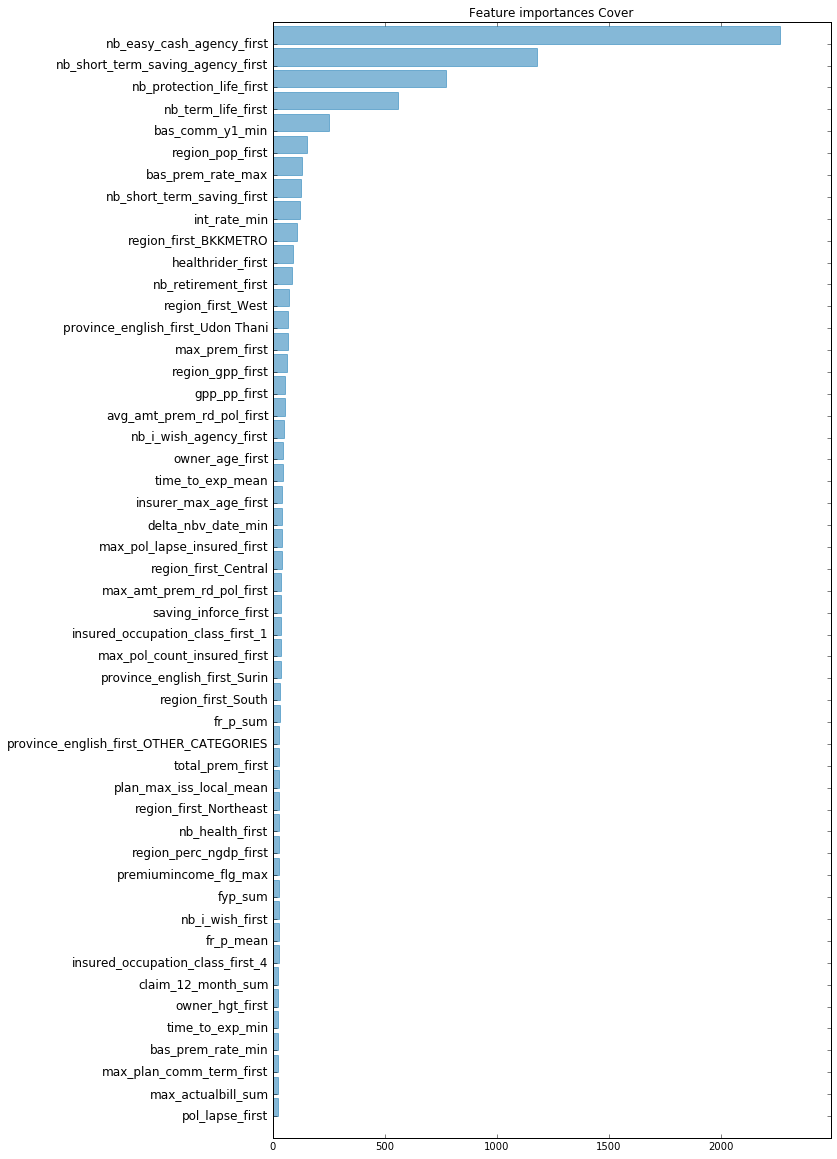

In [19]:
plt.figure(figsize=(10, 20))
plt.title("Feature importances Cover")
plt.barh(feature_importances_top50.index, feature_importances_top50['importance'],
         color='#348ABD', edgecolor='#348ABD', alpha=0.6)
plt.yticks(feature_importances_top50.index, feature_importances_top50['feature'], fontsize=12)
plt.ylim([-1, feature_importances_top50.index.max()+1])
plt.xlim([0, feature_importances_top50['importance'].max()*1.1])
#plt.savefig('/home/jliu/feature_importance_cover.jpg')
plt.show()